In [29]:
import os
import sys
import pymc as pm
import arviz as az
sys.path.append('..')

#autoreload
%load_ext autoreload
%autoreload 2

from src.election_model import *


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
model = ElectionsModel('2024-03-10')
#pm.model_to_graphviz(model.build_model())

In [3]:
def generate_diagnostic_plots(trace, var_names=None):
    """
    Generate diagnostic plots for the given trace.
    
    Parameters:
    - trace: ArviZ InferenceData object
    - var_names: List of variable names to plot (optional)
    """
    
    # 1. Trace plot
    az.plot_trace(trace, var_names=var_names)
    plt.tight_layout()
    plt.show()
    
    # 2. Posterior plot
    az.plot_posterior(trace, var_names=var_names)
    plt.tight_layout()
    plt.show()
    
    # 3. Autocorrelation plot
    az.plot_autocorr(trace, var_names=var_names)
    plt.tight_layout()
    plt.show()
    
    # 4. Pair plot (for selected variables)
    if var_names is not None and len(var_names) > 1:
        az.plot_pair(trace, var_names=var_names[:5])  # Limit to 5 variables for readability
        plt.tight_layout()
        plt.show()
    
    # 5. Forest plot
    az.plot_forest(trace, var_names=var_names)
    plt.tight_layout()
    plt.show()
    
    # 6. Rank plot
    az.plot_rank(trace, var_names=var_names)
    plt.tight_layout()
    plt.show()

    # Print summary statistics
    summary = az.summary(trace, var_names=var_names)
    print("Summary Statistics:")
    print(summary)

In [4]:
if 'prior' not in locals():
    prior = arviz.from_netcdf("../prior.nc")
if 'trace' not in locals():
    trace = arviz.from_netcdf("../trace.nc")
if 'posterior' not in locals():
    posterior = arviz.from_netcdf("../posterior.nc")



In [6]:
import arviz as az

# Calculate and print R-hat values
r_hat = az.rhat(trace)
print("R-hat values:", r_hat)

# Calculate and print effective sample sizes
ess = az.ess(trace)
print("Effective sample sizes:", ess)

# Plot energy distribution
az.plot_energy(trace)
plt.show()

KeyboardInterrupt: 

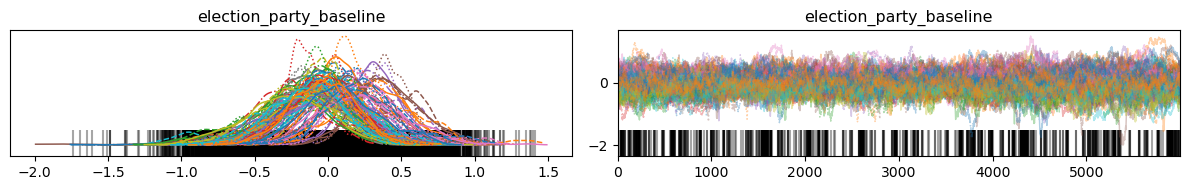

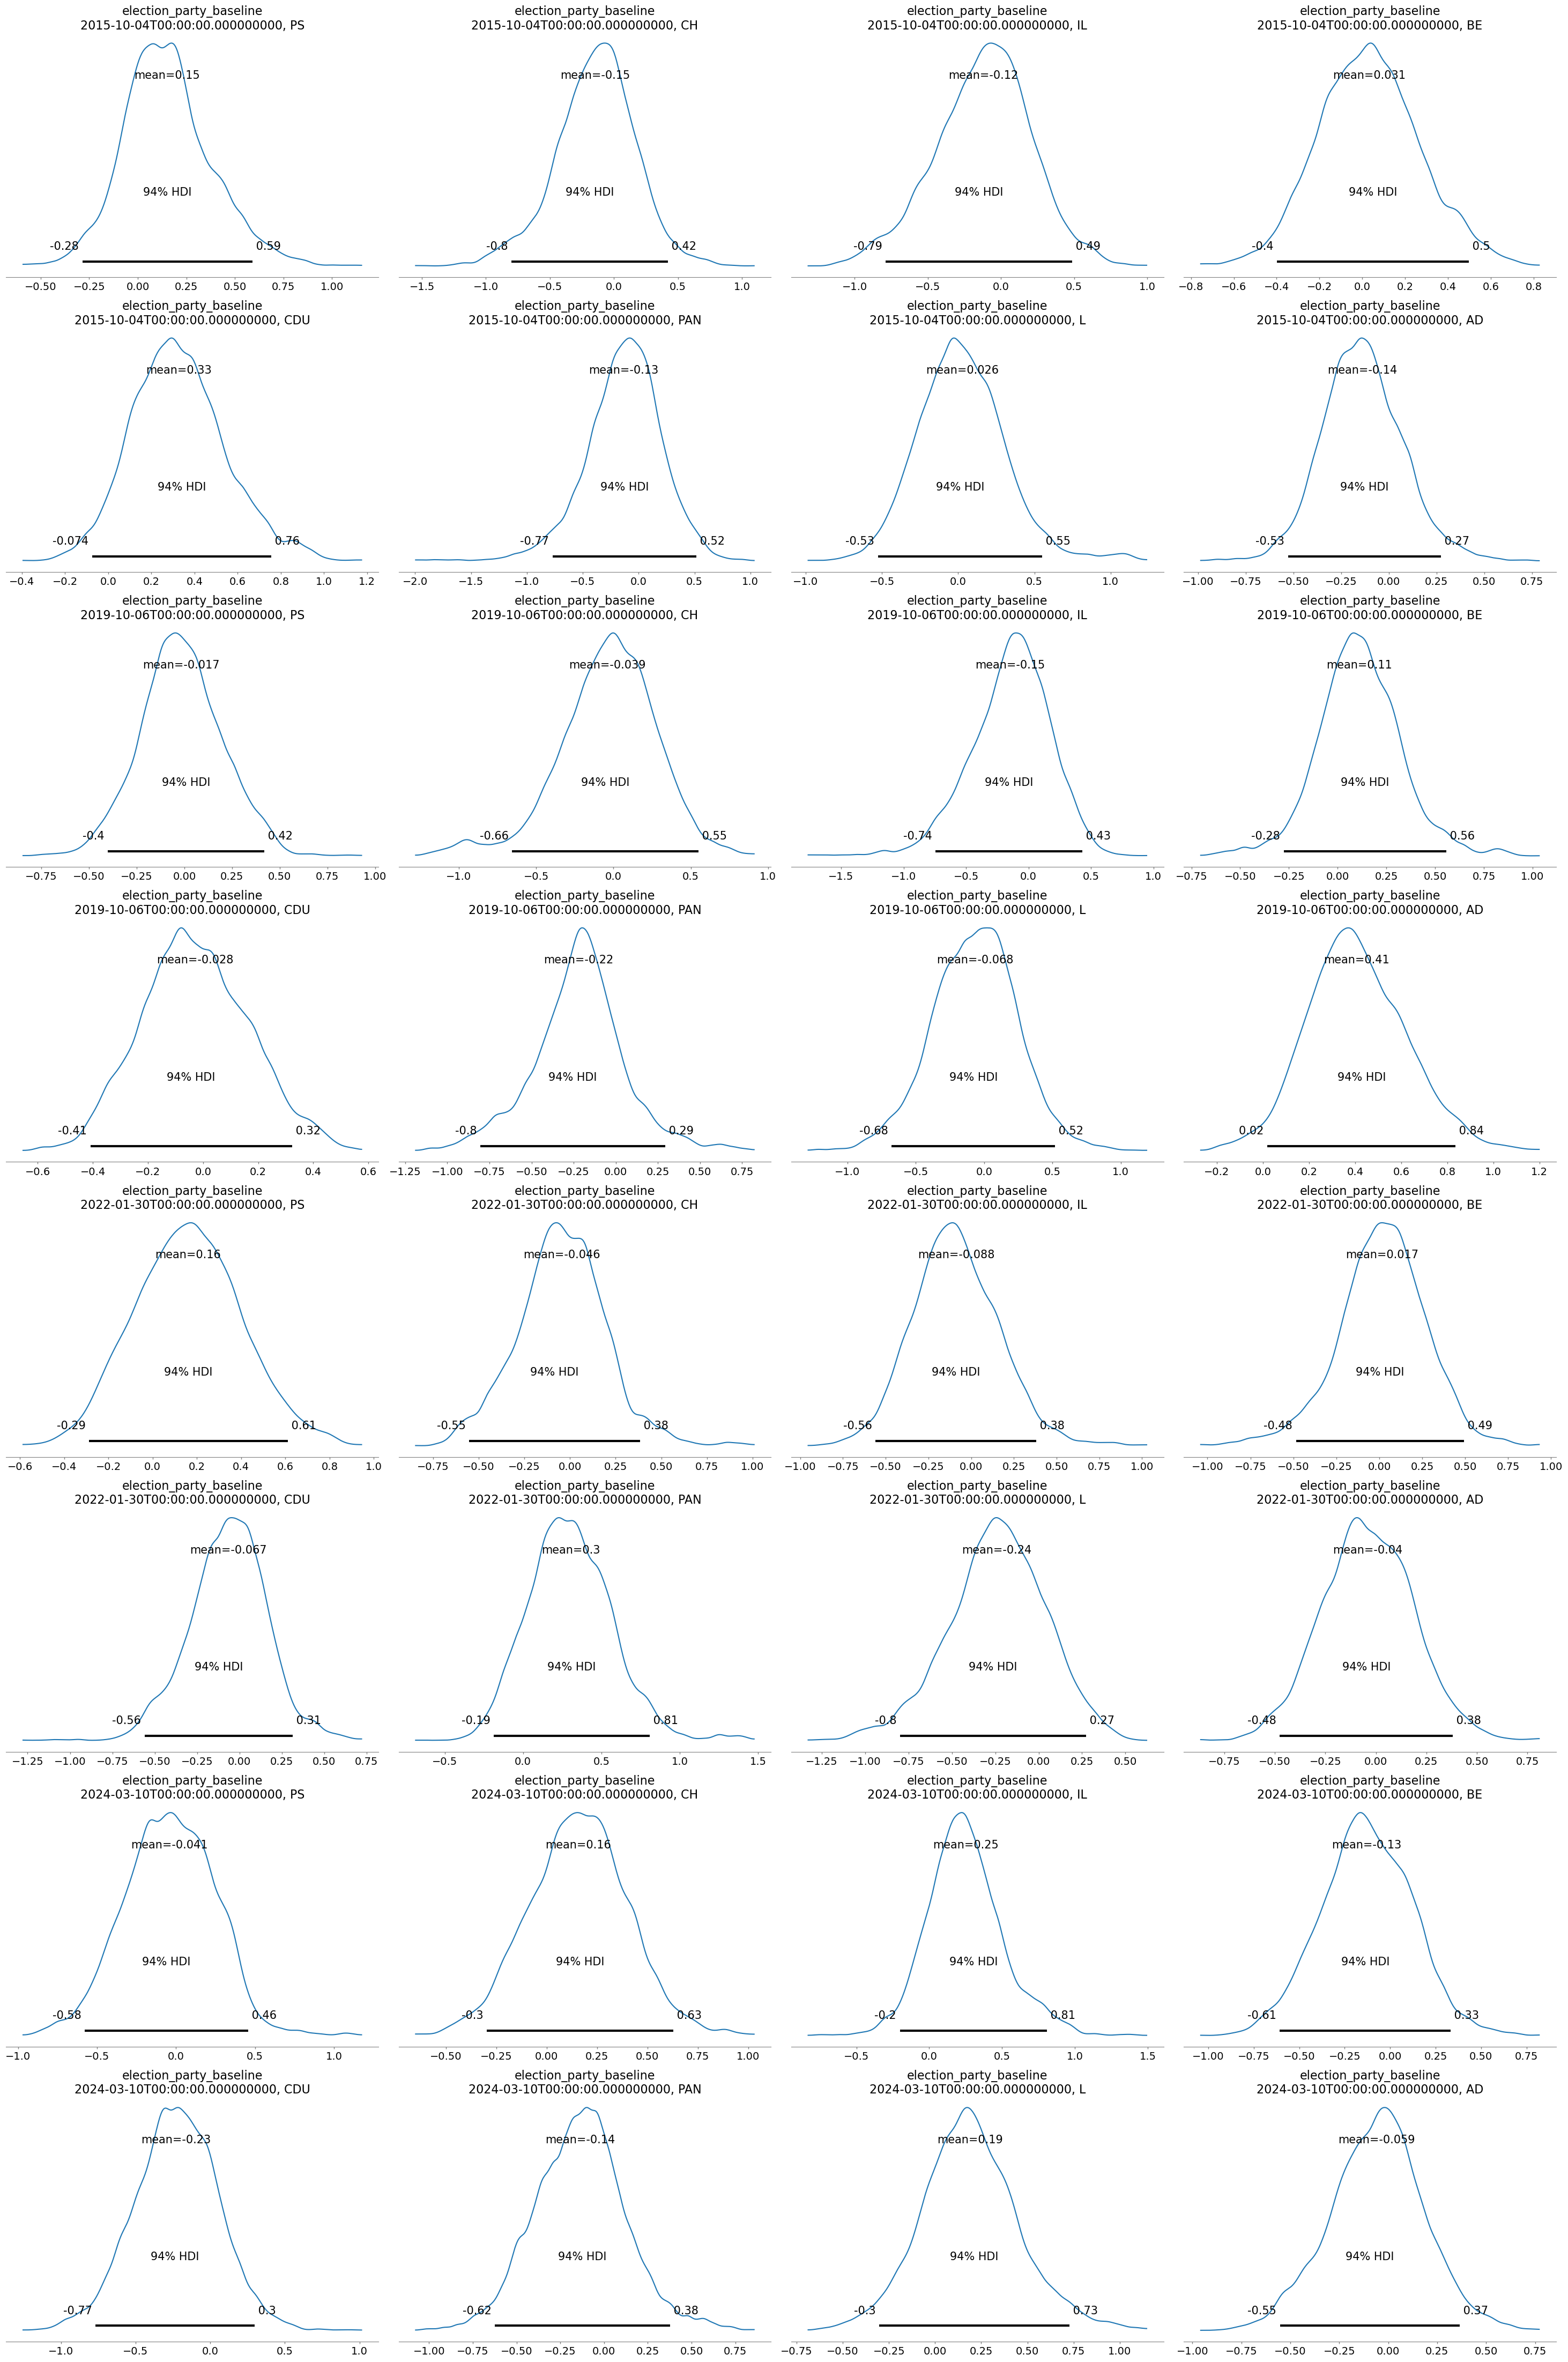

/Users/bernardo.caldas/miniforge3/envs/bayes3/lib/python3.12/site-packages/arviz/plots/plot_utils.py:270: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (128) in plot_autocorr, generating only 40 plots
  warnings.warn(


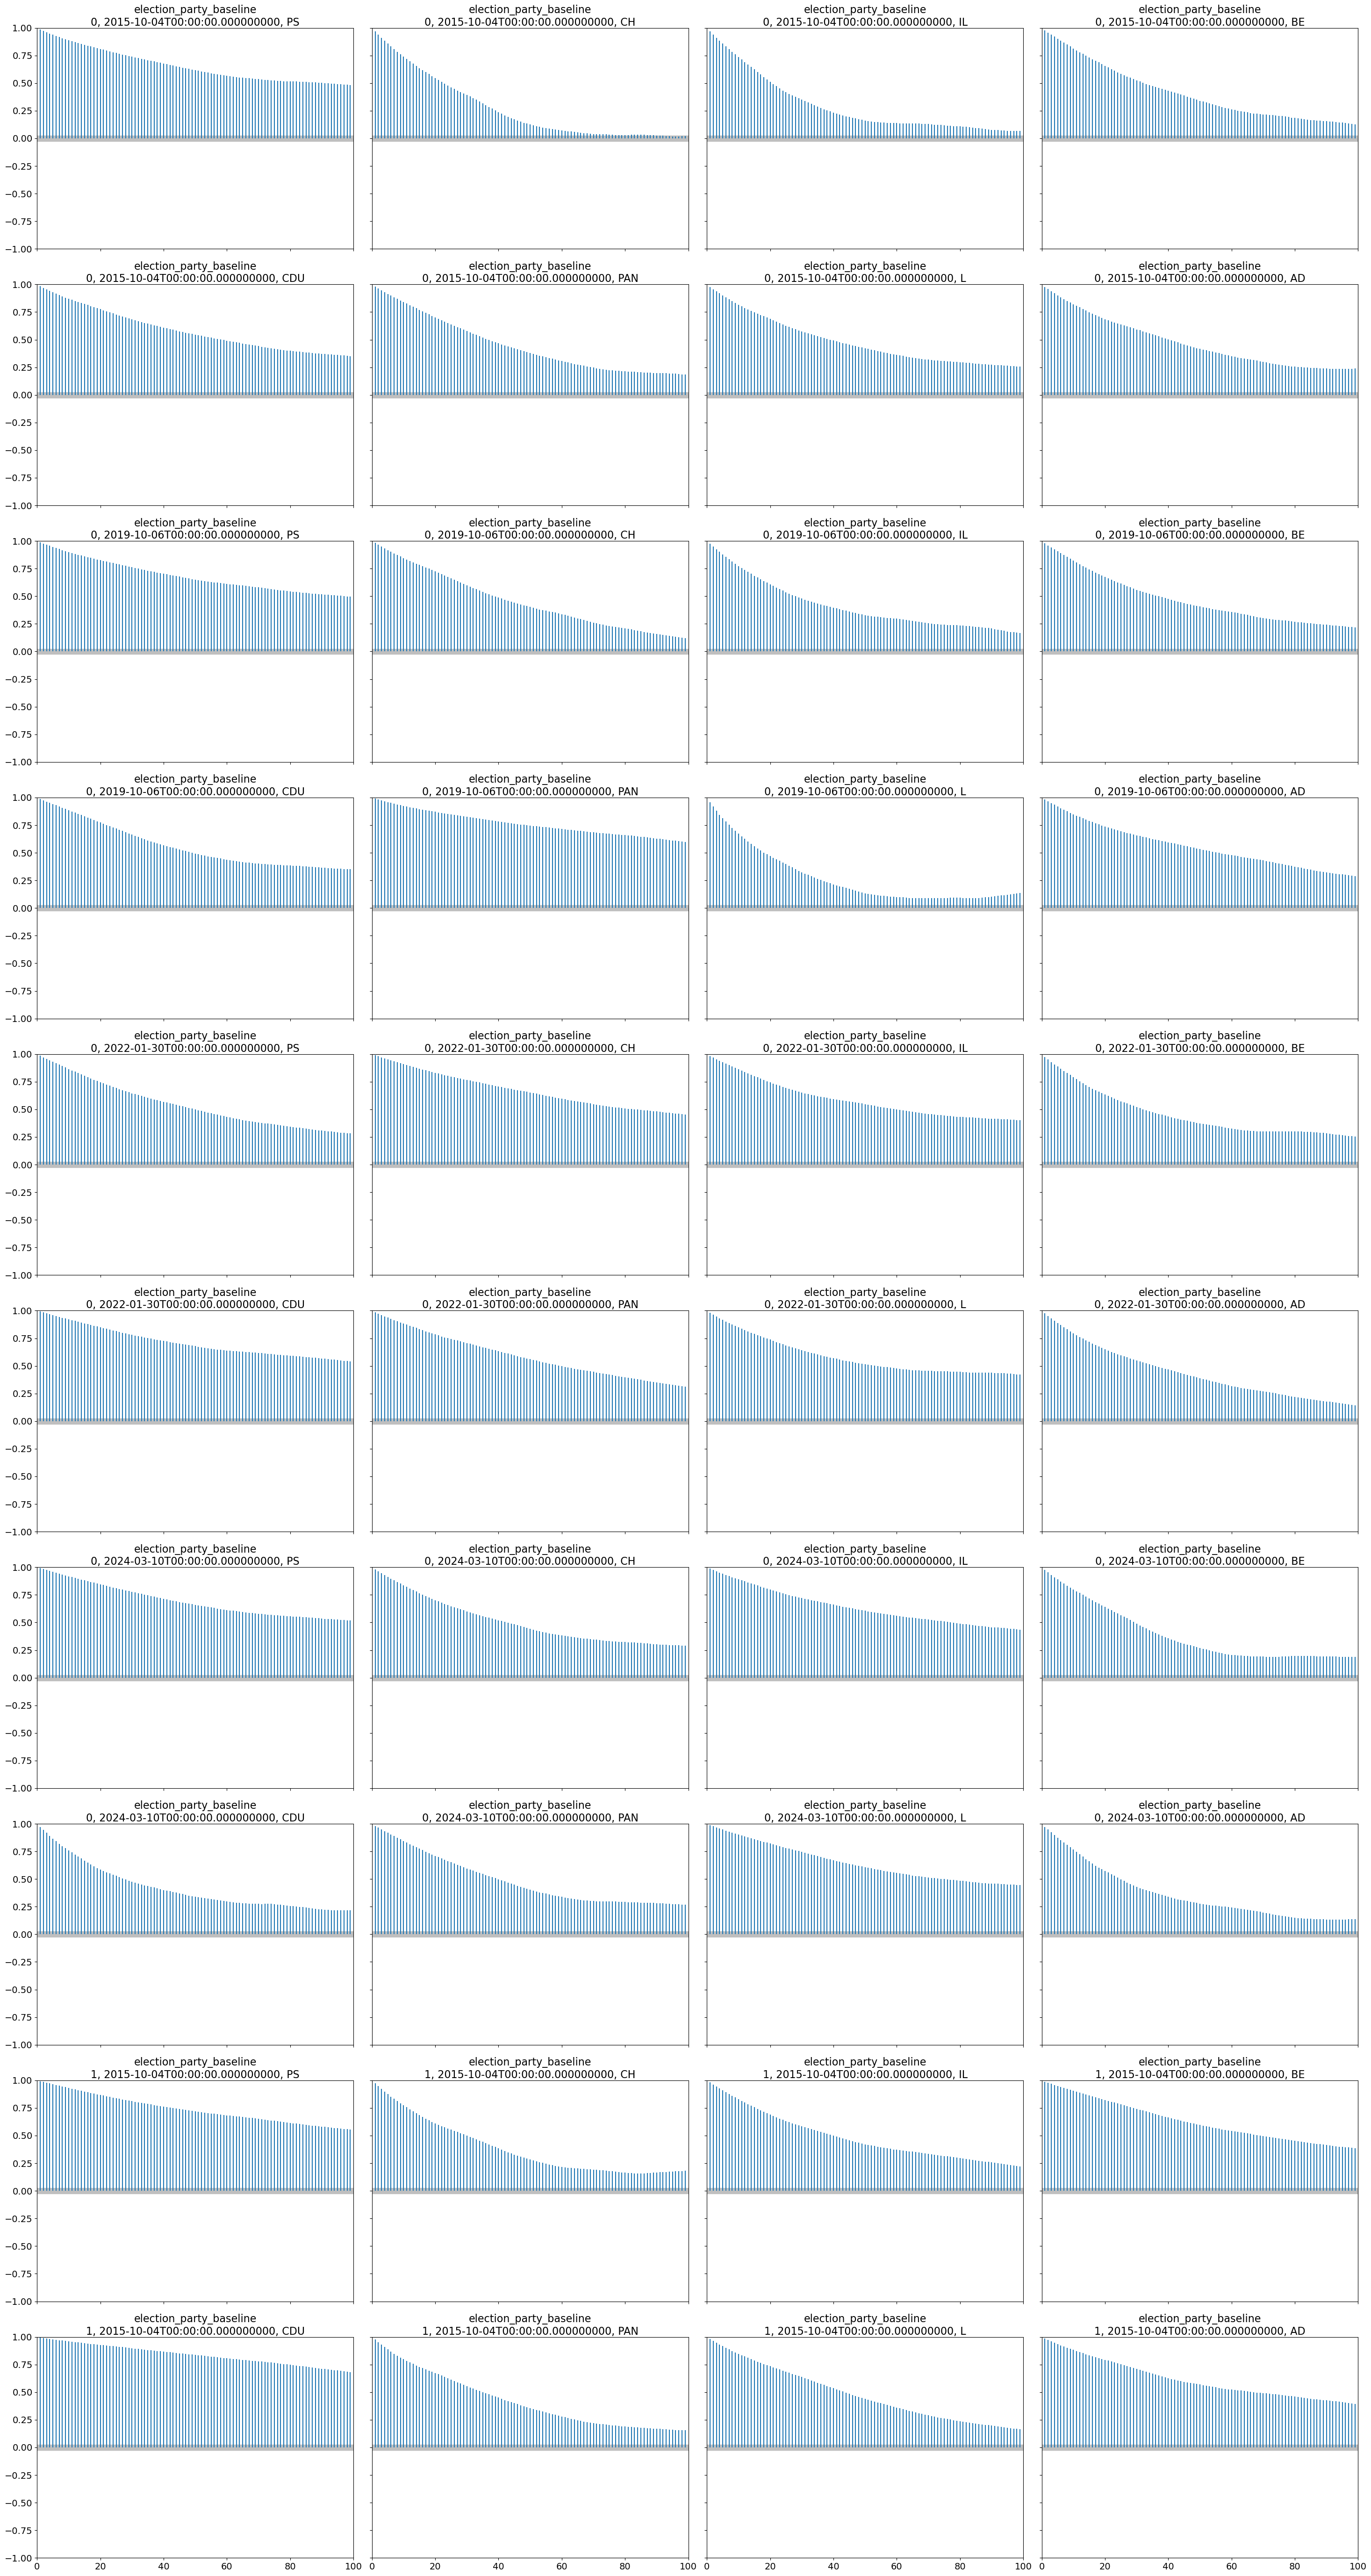

/var/folders/gq/8yyn338x5db50hmj51ndrvtc0000gn/T/ipykernel_60074/3471337069.py:33: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


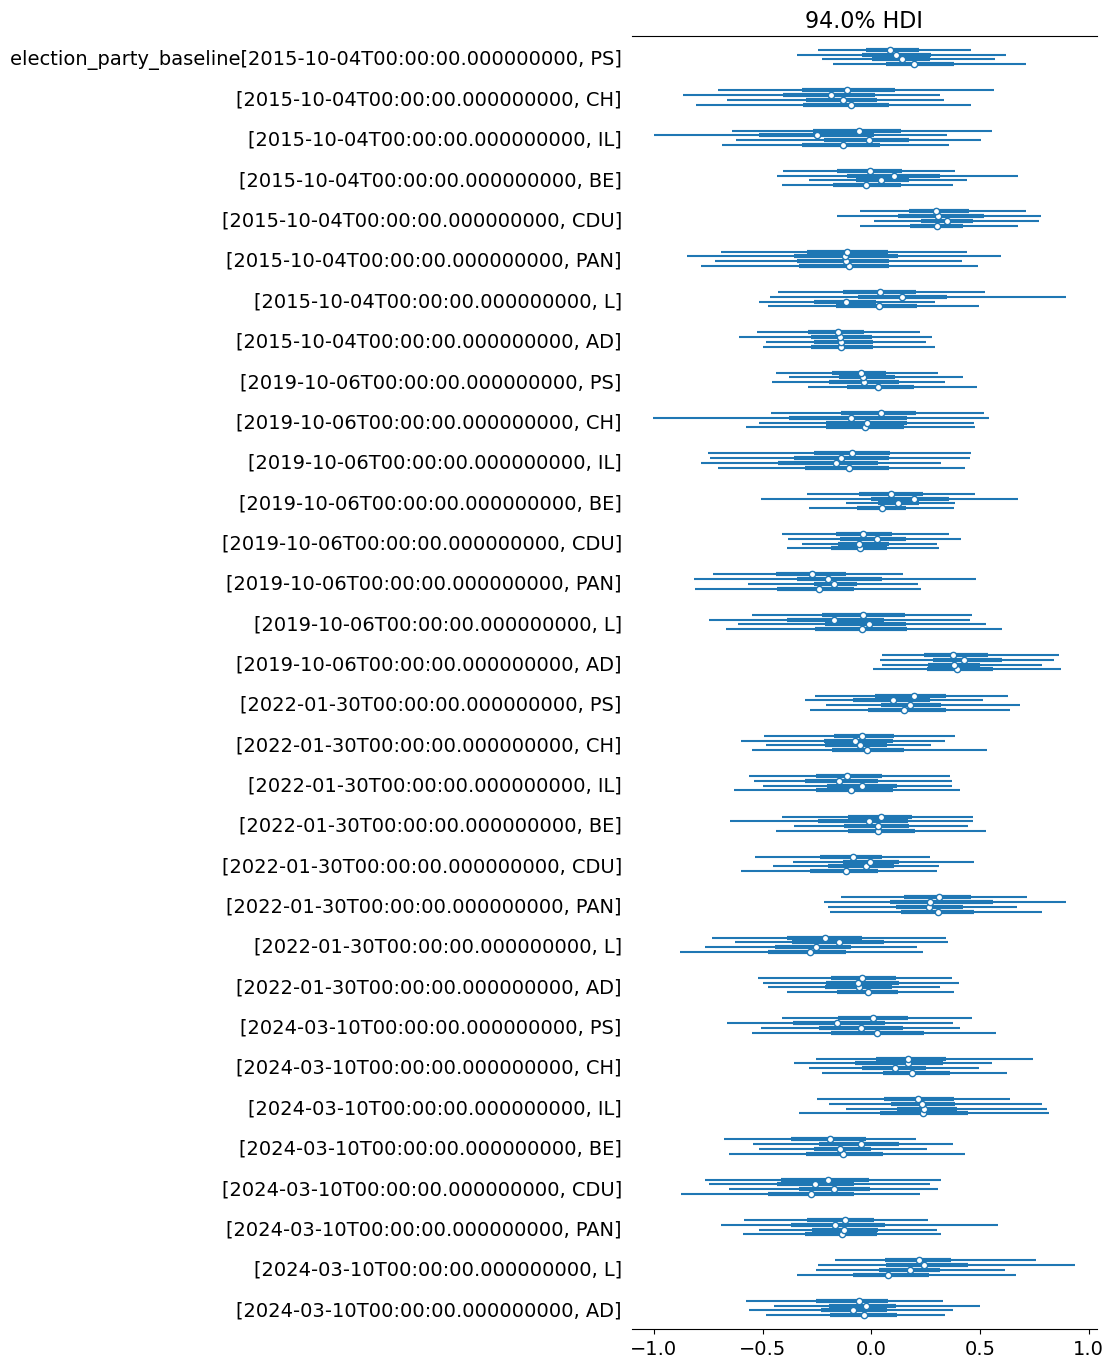

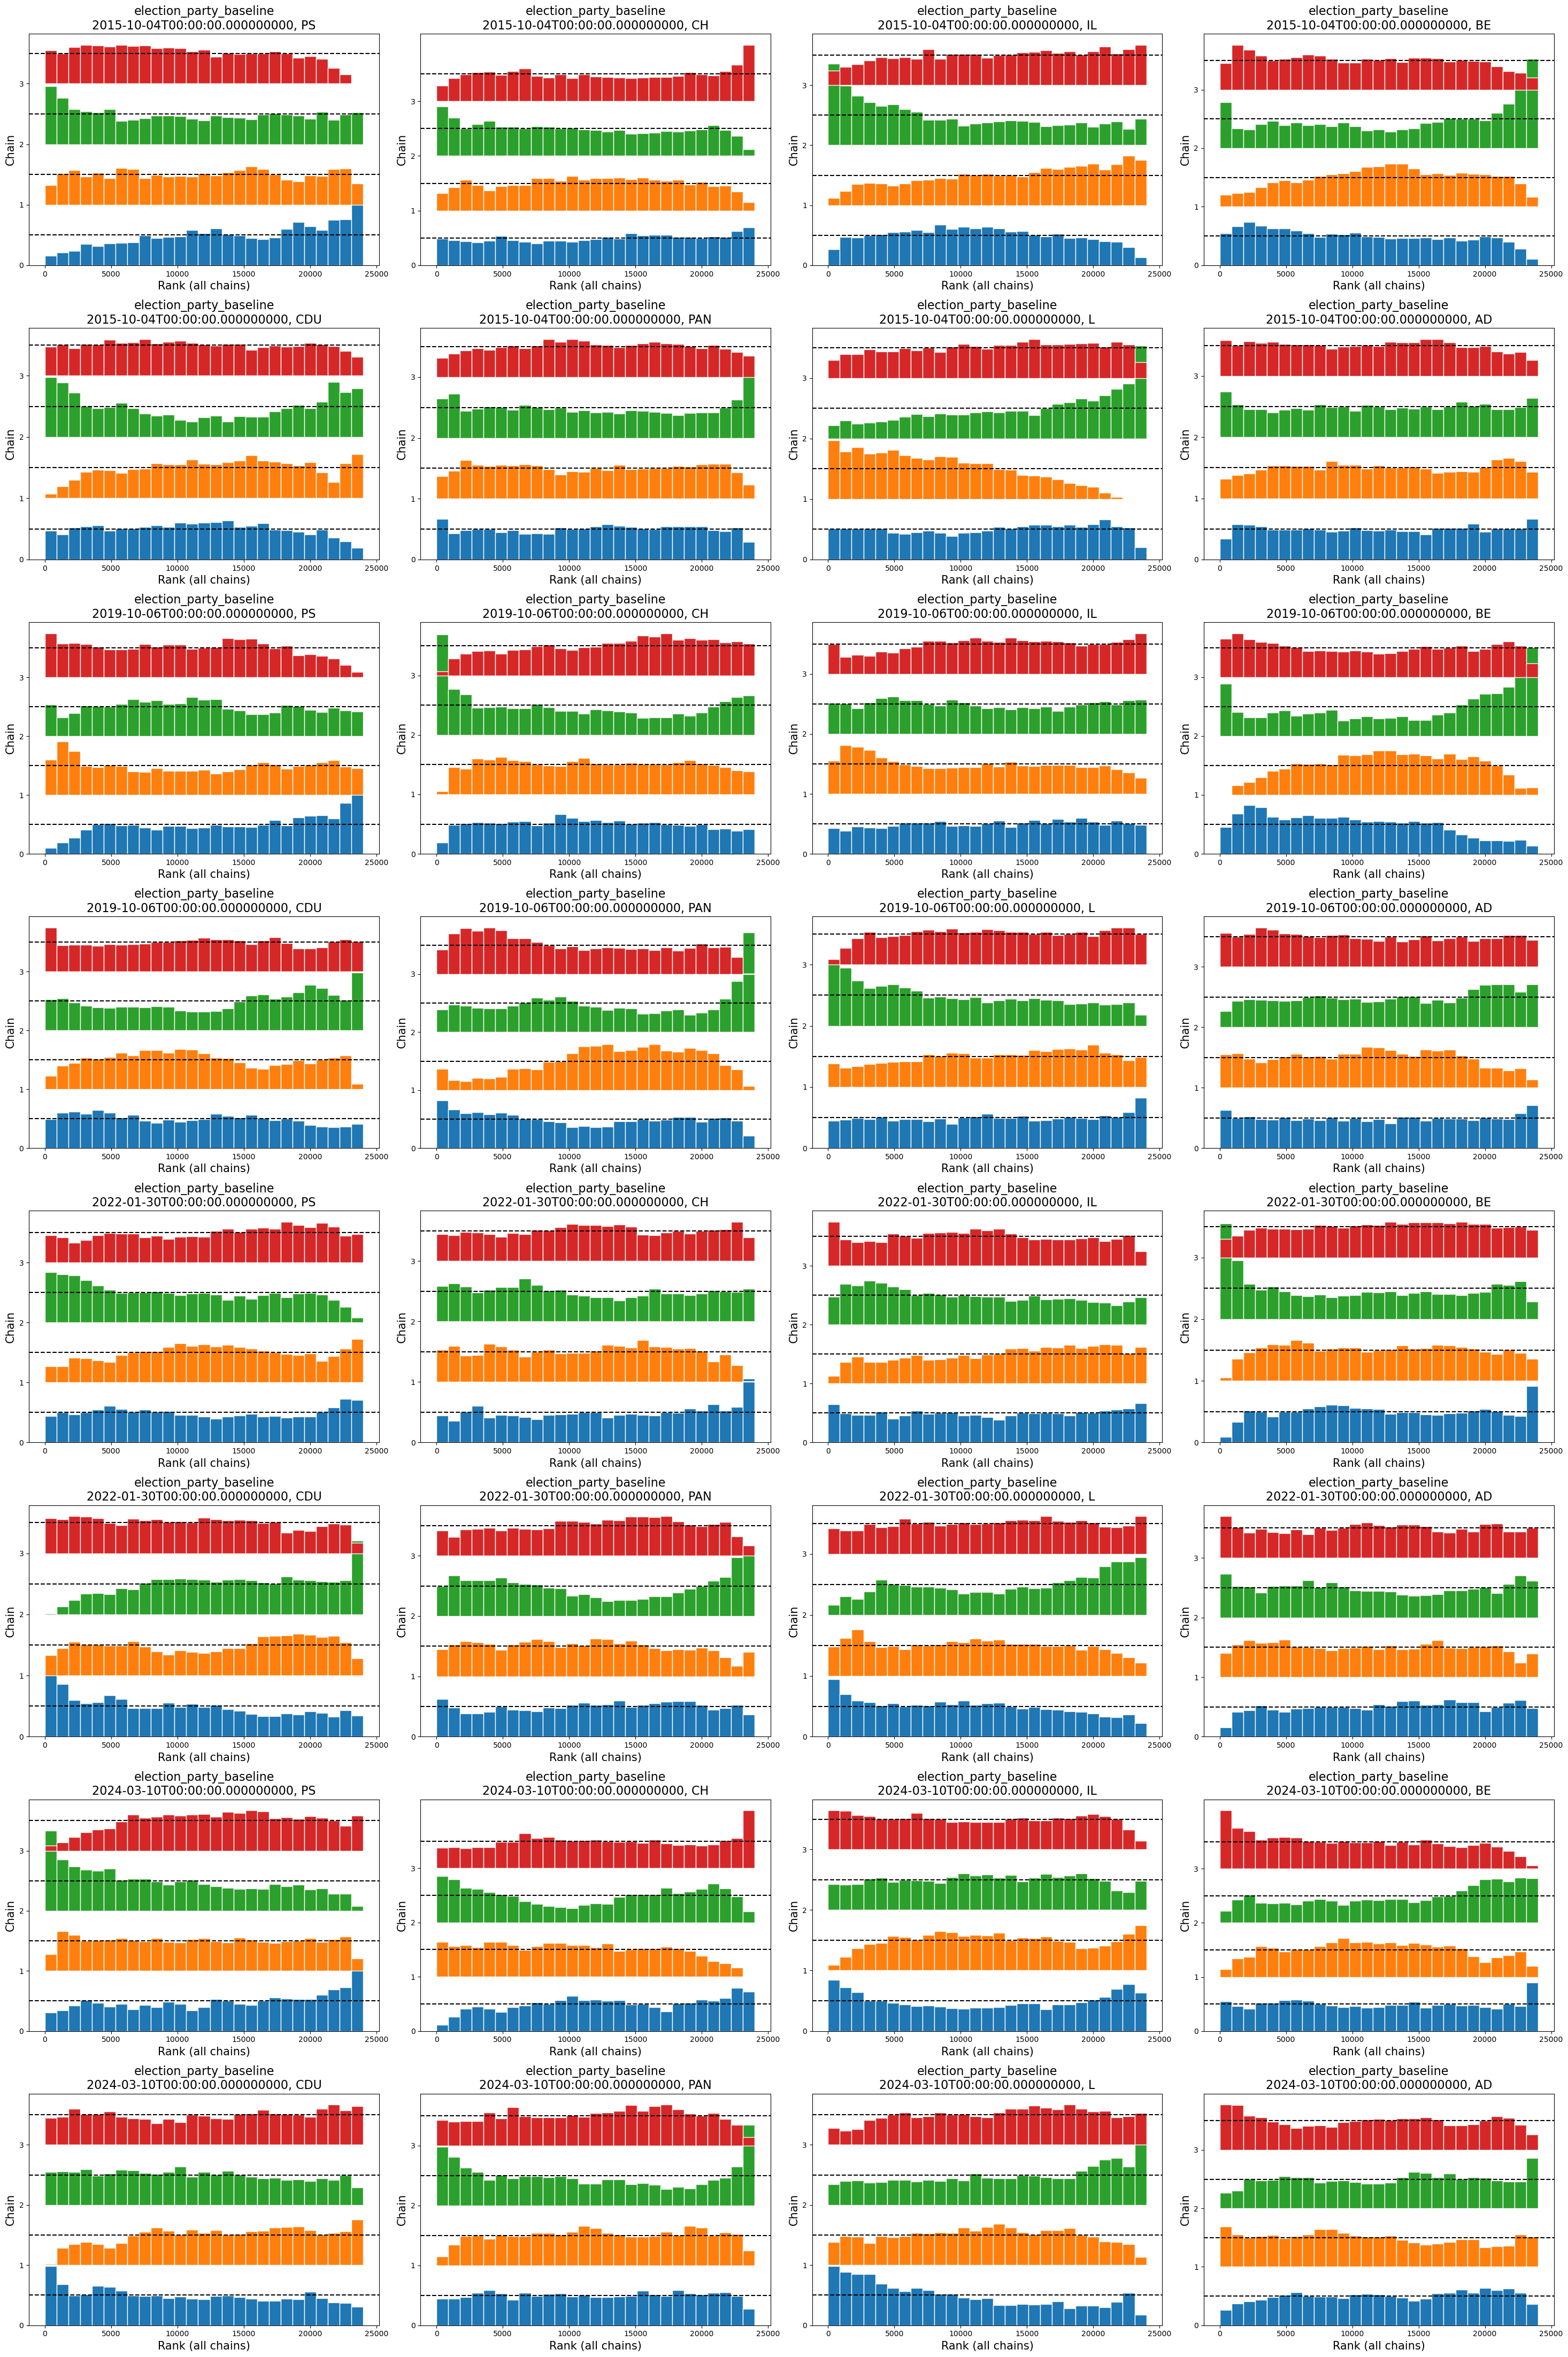

Summary Statistics:
                                                     mean     sd  hdi_3%  \
election_party_baseline[2015-10-04T00:00:00.000...  0.152  0.229  -0.285   
election_party_baseline[2015-10-04T00:00:00.000... -0.145  0.314  -0.801   
election_party_baseline[2015-10-04T00:00:00.000... -0.121  0.329  -0.787   
election_party_baseline[2015-10-04T00:00:00.000...  0.031  0.238  -0.399   
election_party_baseline[2015-10-04T00:00:00.000...  0.328  0.219  -0.074   
election_party_baseline[2015-10-04T00:00:00.000... -0.133  0.342  -0.769   
election_party_baseline[2015-10-04T00:00:00.000...  0.026  0.292  -0.526   
election_party_baseline[2015-10-04T00:00:00.000... -0.138  0.212  -0.528   
election_party_baseline[2019-10-06T00:00:00.000... -0.017  0.216  -0.401   
election_party_baseline[2019-10-06T00:00:00.000... -0.039  0.319  -0.656   
election_party_baseline[2019-10-06T00:00:00.000... -0.146  0.319  -0.743   
election_party_baseline[2019-10-06T00:00:00.000...  0.111  0.216  -0

In [7]:
var_names = ['election_party_baseline']
generate_diagnostic_plots(trace, var_names=var_names)

In [ ]:

#az.rcParams["plot.max_subplots"] = 200
az.plot_trace(trace, var_names=['house_effects'])

Shape of mean_time_effect: (1560, 8)
Shape of mean_baseline: (8,)
Shape of countdown: (1560,)
Number of parties: 8
Shape of reshaped_baseline: (8, 1560)
Shape of total_effect: (8, 1560)
Shape of total_effect_probs: (8, 1560)


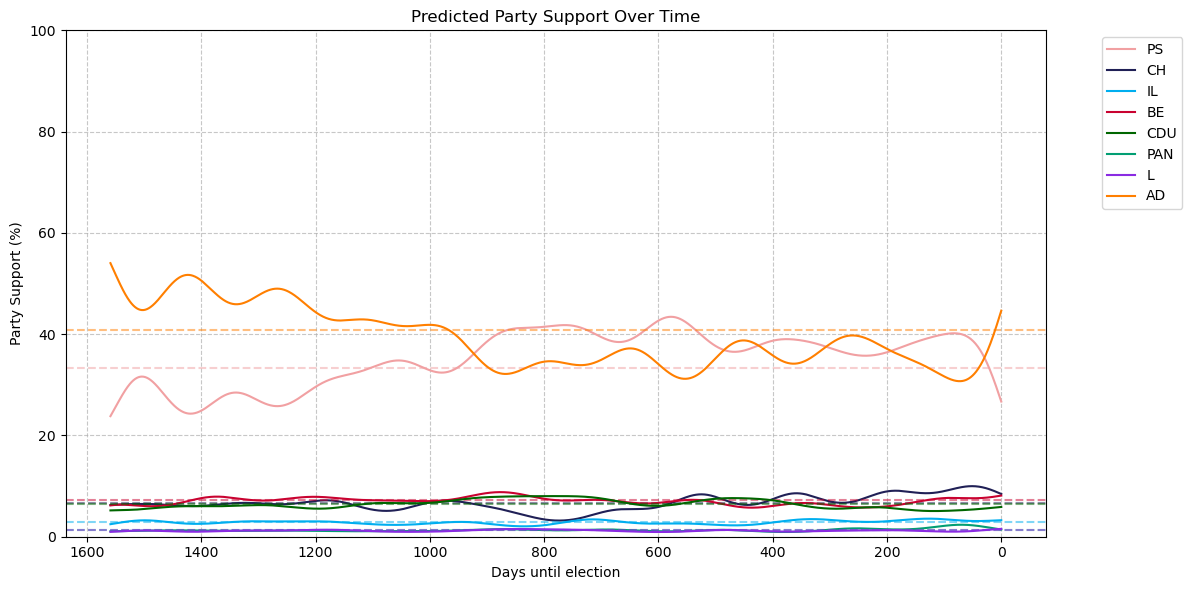

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.special import softmax

# Assuming 'trace' is your InferenceData object
party_time_effect = trace.posterior['party_time_effect']
party_baseline = trace.posterior['party_baseline']

# Get the unique parties and countdown values
parties = party_time_effect.coords['parties_complete'].values
countdown = party_time_effect.coords['countdown'].values

# Calculate the mean effect across chains and draws
mean_time_effect = party_time_effect.mean(dim=['chain', 'draw'])
mean_baseline = party_baseline.mean(dim=['chain', 'draw'])

print("Shape of mean_time_effect:", mean_time_effect.shape)
print("Shape of mean_baseline:", mean_baseline.shape)
print("Shape of countdown:", countdown.shape)
print("Number of parties:", len(parties))

# Define colors for Portuguese political parties
party_colors = {
    'PS': '#f1a0a2',  # Light pink
    'AD': '#ff7f00',  # Orange (for PSD/CDS alliance)
    'CH': '#202056',  # Dark blue
    'IL': '#00aeef',  # Light blue
    'BE': '#c90230',  # Red
    'CDU': '#006600',  # Green
    'PAN': '#029e73',  # Teal
    'L': '#8a2be2'    # Purple
}

# Create the plot
plt.figure(figsize=(12, 6))

# Apply softmax to get probabilities
baseline_probs = softmax(mean_baseline.values)

# Reshape mean_baseline to be compatible with mean_time_effect
reshaped_baseline = mean_baseline.values[:, np.newaxis].repeat(len(countdown), axis=1)
total_effect = reshaped_baseline + mean_time_effect.values.T
total_effect_probs = softmax(total_effect, axis=0)

print("Shape of reshaped_baseline:", reshaped_baseline.shape)
print("Shape of total_effect:", total_effect.shape)
print("Shape of total_effect_probs:", total_effect_probs.shape)

for i, party in enumerate(parties):
    if party in party_colors:
        # Plot the baseline
        plt.axhline(y=baseline_probs[i] * 100, color=party_colors[party], linestyle='--', alpha=0.5)
        
        # Plot the baseline + time effect
        plt.plot(countdown, total_effect_probs[i, :] * 100, label=party, color=party_colors[party])

plt.xlabel('Days until election')
plt.ylabel('Party Support (%)')
plt.title('Predicted Party Support Over Time')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.7)

# Reverse x-axis so that it counts down to election day
plt.gca().invert_xaxis()

# Set y-axis limits
plt.ylim(0, 100)

plt.tight_layout()
plt.show()

In [7]:
print(trace.posterior.data_vars.keys())

KeysView(Data variables:
    concentration_polls                        (chain, draw) float64 192kB ...
    concentration_results                      (chain, draw) float64 192kB ...
    election_party_baseline                    (chain, draw, elections, parties_complete) float64 6MB ...
    election_party_baseline_sd                 (chain, draw) float64 192kB ...
    election_party_time_effect                 (chain, draw, countdown, parties_complete, elections) float64 10GB ...
    election_party_time_effect_weighted        (chain, draw, countdown, parties_complete, elections) float64 10GB ...
    election_party_time_weight                 (chain, draw, parties_complete, elections) float64 6MB ...
    gp_coef_baseline_0                         (chain, draw, gp_basis_0, parties_complete) float64 46MB ...
    gp_coef_baseline_1                         (chain, draw, gp_basis_1, parties_complete) float64 46MB ...
    gp_coef_baseline_2                         (chain, draw, gp_basis_2, p

In [18]:
print(trace)
print("\nSample stats:")
print(trace.sample_stats)

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data

Sample stats:
<xarray.Dataset> Size: 1MB
Dimensions:          (chain: 4, draw: 6000)
Coordinates:
  * chain            (chain) int64 32B 0 1 2 3
  * draw             (draw) int64 48kB 0 1 2 3 4 5 ... 5995 5996 5997 5998 5999
Data variables:
    acceptance_rate  (chain, draw) float64 192kB ...
    diverging        (chain, draw) bool 24kB False False False ... False False
    energy           (chain, draw) float64 192kB 1.799e+04 ... 1.797e+04
    lp               (chain, draw) float64 192kB 1.597e+04 ... 1.594e+04
    n_steps          (chain, draw) int64 192kB ...
    step_size        (chain, draw) float64 192kB ...
    tree_depth       (chain, draw) int64 192kB ...
Attributes:
    created_at:     2024-09-15T20:26:19.599205+00:00
    arviz_version:  0.19.0


In [19]:
diverging = trace.sample_stats.diverging.values
print(f"Shape of diverging array: {diverging.shape}")
print(f"Number of divergences: {np.sum(diverging)}")

Shape of diverging array: (4, 6000)
Number of divergences: 908


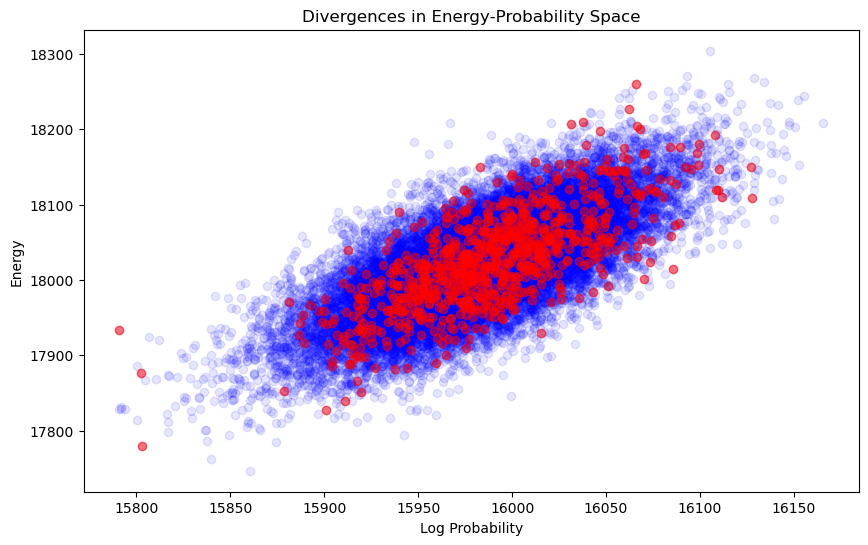

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Flatten the arrays if they're multi-dimensional
lp = trace.sample_stats.lp.values.flatten()
energy = trace.sample_stats.energy.values.flatten()
diverging = diverging.flatten()

plt.figure(figsize=(10, 6))
plt.scatter(lp, energy, c='b', alpha=0.1)
plt.scatter(lp[diverging], energy[diverging], c='r', alpha=0.5)
plt.xlabel('Log Probability')
plt.ylabel('Energy')
plt.title('Divergences in Energy-Probability Space')
plt.show()

In [27]:
import arviz as az
import pandas as pd

# Set pandas display options to show all rows
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

params_to_check = [
    'party_baseline',
    'election_party_baseline',
    'house_election_effects',
    'poll_bias',
    'concentration_polls',
    'concentration_results',
    'party_baseline_sd',
    'election_party_baseline_sd',
    'house_election_effects_sd',
    'lsd_baseline',
    'lsd_election_party_sd'
]
summary = az.summary(trace, var_names=params_to_check)
print(summary)

# Reset pandas display options (optional)
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')
pd.reset_option('display.width')
pd.reset_option('display.max_colwidth')

                                                                                      mean  \
party_baseline[PS]                                                                   1.690   
party_baseline[CH]                                                                   0.074   
party_baseline[IL]                                                                  -0.742   
party_baseline[BE]                                                                   0.171   
party_baseline[CDU]                                                                  0.055   
party_baseline[PAN]                                                                 -1.550   
party_baseline[L]                                                                   -1.595   
party_baseline[AD]                                                                   1.896   
election_party_baseline[2015-10-04T00:00:00.000000000, PS]                           0.152   
election_party_baseline[2015-10-04T00:00:00.000000000, CH]  

In [38]:
model = ElectionsModel('2024-03-10')
ppc_results = model.posterior_predictive_check(posterior)

Available keys in posterior_predictive: KeysView(Data variables:
    N_approve                            (chain, draw, observations, parties_complete) int64 673MB ...
    R                                    (chain, draw, elections_observed, parties_complete) int64 5MB ...
    election_party_baseline              (chain, draw, elections, parties_complete) float64 6MB ...
    election_party_time_effect           (chain, draw, countdown, parties_complete, elections) float64 10GB ...
    election_party_time_effect_weighted  (chain, draw, countdown, parties_complete, elections) float64 10GB ...
    election_party_time_weight           (chain, draw, parties_complete, elections) float64 6MB ...
    house_effects                        (chain, draw, pollsters, parties_complete) float64 15MB ...
    house_election_effects               (chain, draw, pollsters, parties_complete, elections) float64 61MB ...
    latent_pop_t0                        (chain, draw, elections, parties_complete) floa

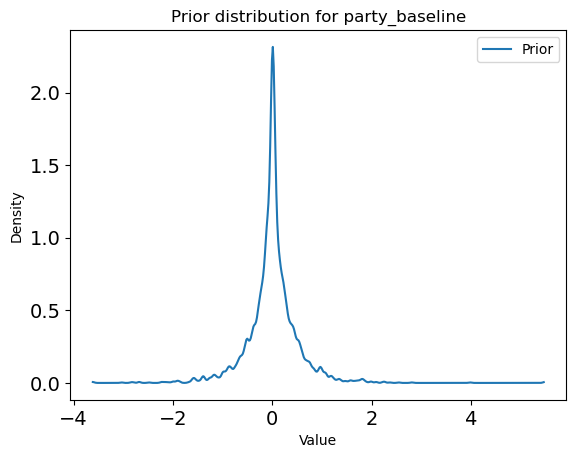

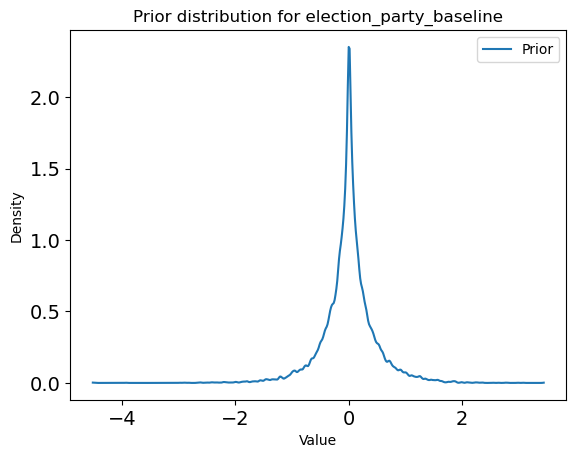

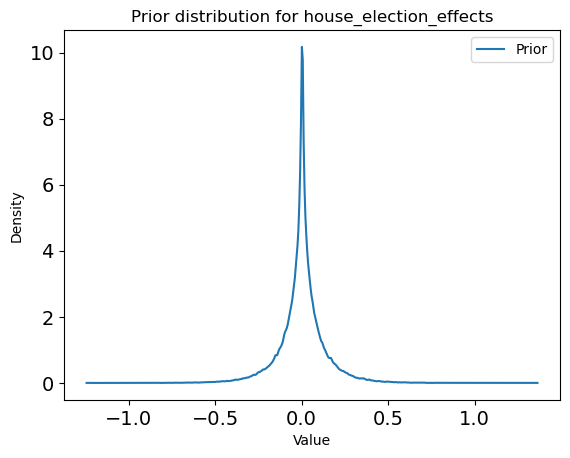

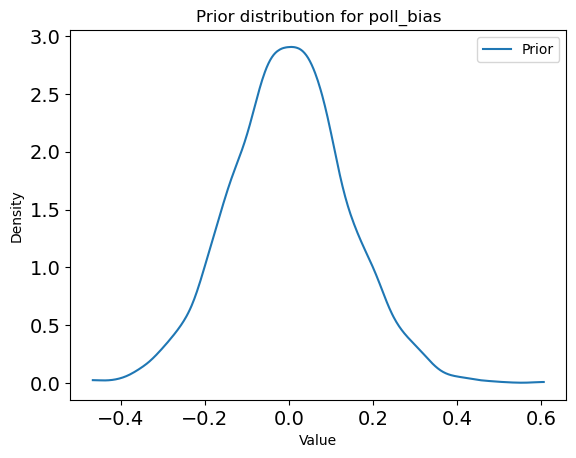

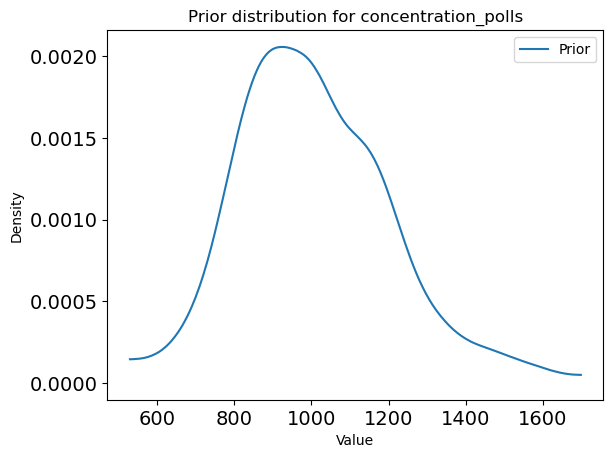

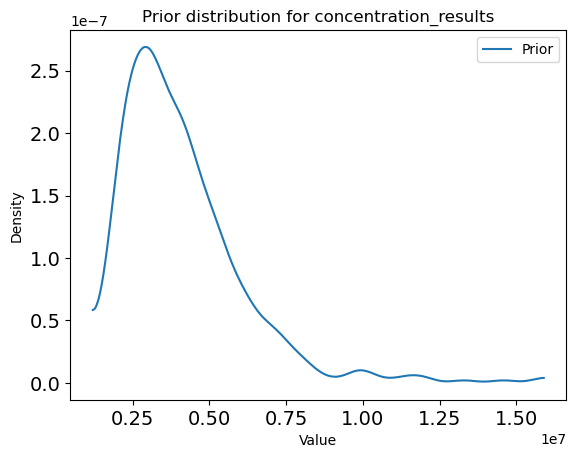

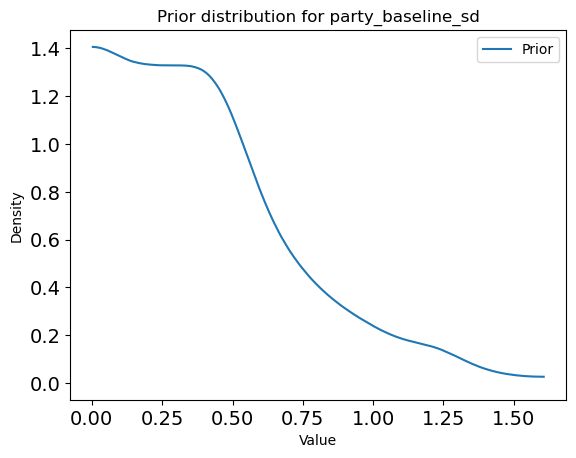

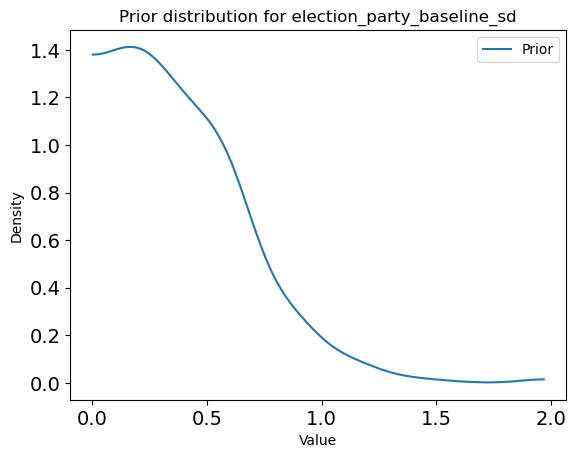

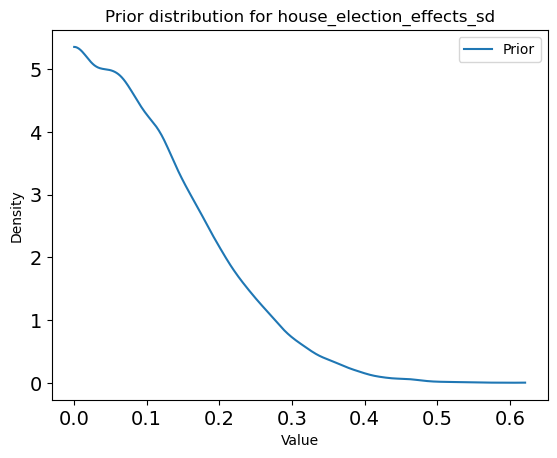

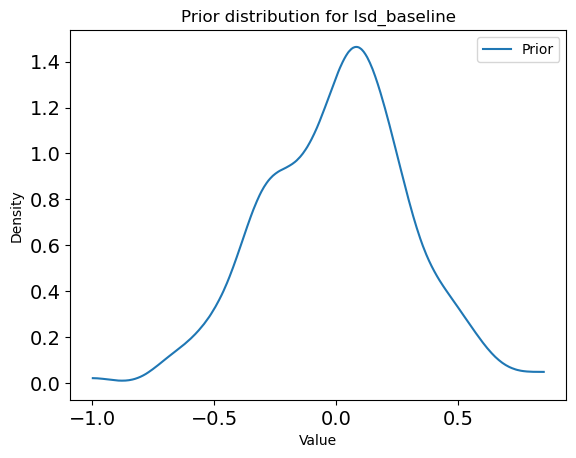

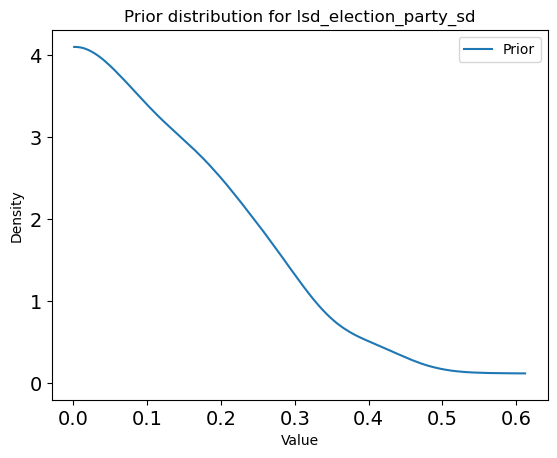

'observed_polls' not found in prior samples or observed data
'observed_results' not found in prior samples or observed data
                                                                                      mean  \
party_baseline[PS]                                                                   1.690   
party_baseline[CH]                                                                   0.074   
party_baseline[IL]                                                                  -0.742   
party_baseline[BE]                                                                   0.171   
party_baseline[CDU]                                                                  0.055   
party_baseline[PAN]                                                                 -1.550   
party_baseline[L]                                                                   -1.595   
party_baseline[AD]                                                                   1.896   
election_party_baseline[2015-1

In [46]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np

def plot_prior(prior, var_name):
    if var_name in prior.prior:
        prior_samples = prior.prior[var_name].values
        
        if prior_samples.ndim > 1:
            # Flatten multi-dimensional arrays
            prior_samples = prior_samples.flatten()
        
        az.plot_kde(prior_samples, plot_kwargs={'label': 'Prior'})
        plt.title(f'Prior distribution for {var_name}')
        plt.xlabel('Value')
        plt.ylabel('Density')
        plt.legend()
        plt.show()
    else:
        print(f"Variable {var_name} not found in prior samples")

# Create the model
model = ElectionsModel('2024-03-10').build_model()

# List of parameters to check
params_to_check = [
    'party_baseline',
    'election_party_baseline',
    'house_election_effects',
    'poll_bias',
    'concentration_polls',
    'concentration_results',
    'party_baseline_sd',
    'election_party_baseline_sd',
    'house_election_effects_sd',
    'lsd_baseline',
    'lsd_election_party_sd'
]

# Plot prior distributions for each parameter
for param in params_to_check:
    plot_prior(prior, param)

# Generate prior predictive checks
# Plot prior predictive distributions for observed data
if 'observed_polls' in prior.observed_data and 'observed_polls' in prior.prior_predictive:
    az.plot_ppc(prior, kind='cumulative', data_pairs={"observed_polls": "observed_polls"})
    plt.title('Prior Predictive Check for Observed Polls')
    plt.show()
else:
    print("'observed_polls' not found in prior samples or observed data")

if 'observed_results' in prior.observed_data and 'observed_results' in prior.prior_predictive:
    az.plot_ppc(prior, kind='cumulative', data_pairs={"observed_results": "observed_results"})
    plt.title('Prior Predictive Check for Observed Results')
    plt.show()
else:
    print("'observed_results' not found in prior samples or observed data")

# Now proceed with the posterior analysis
import pandas as pd

# Set pandas display options to show all rows
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

summary = az.summary(trace, var_names=params_to_check)
print(summary)

# Reset pandas display options (optional)
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')
pd.reset_option('display.width')
pd.reset_option('display.max_colwidth')

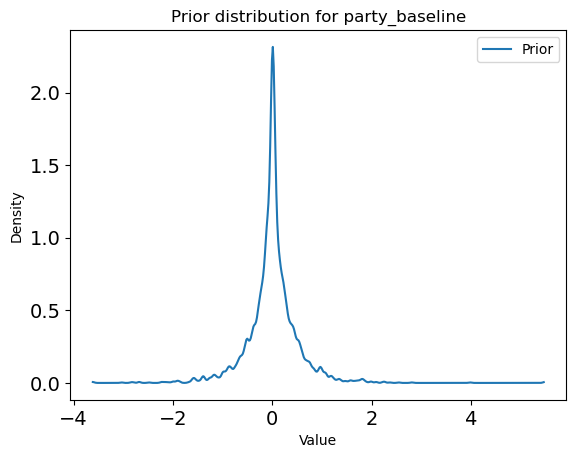

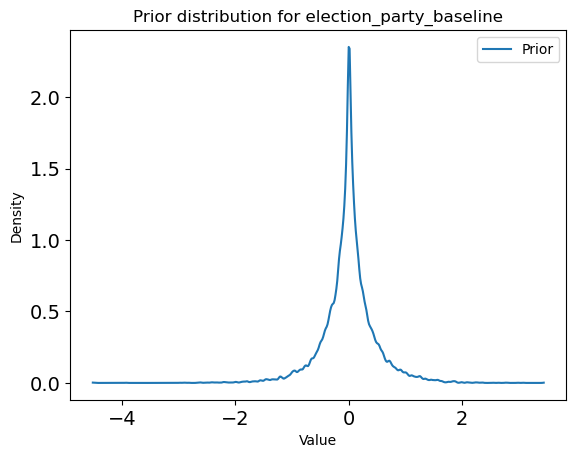

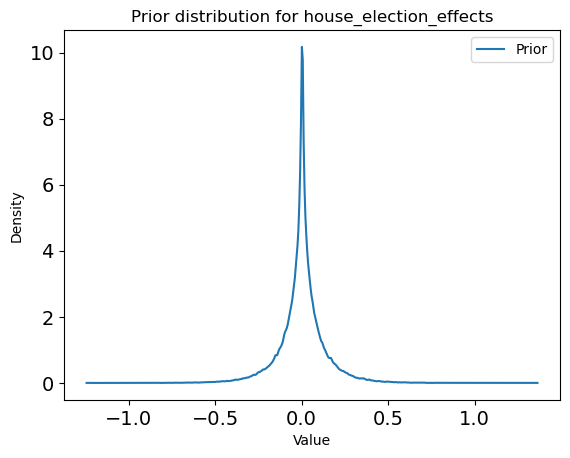

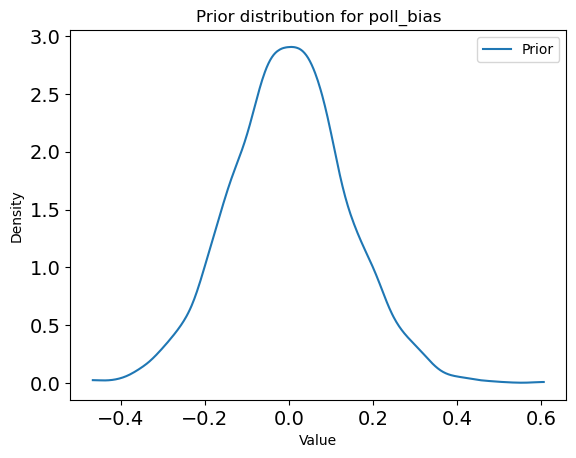

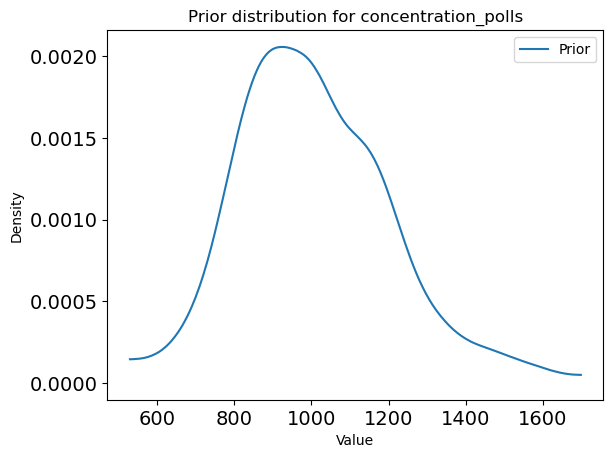

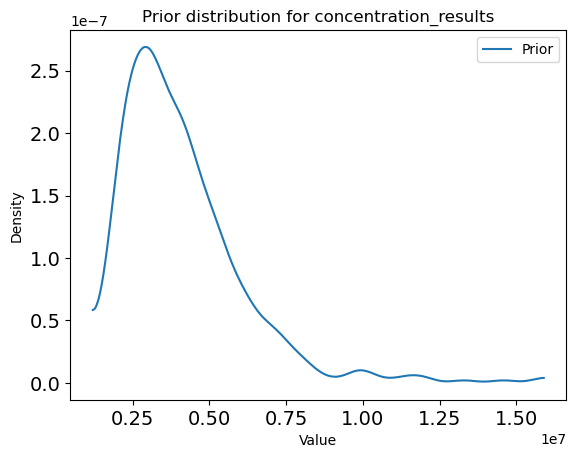

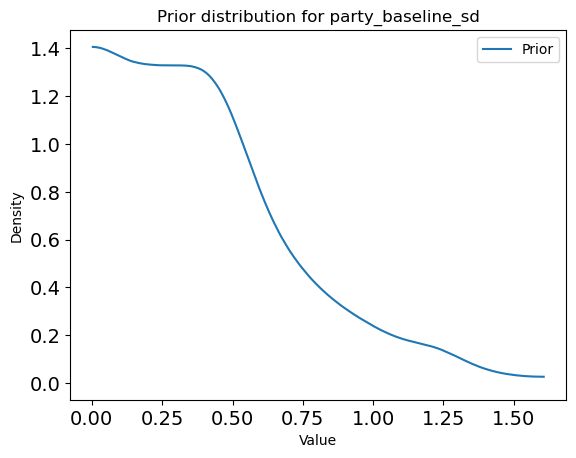

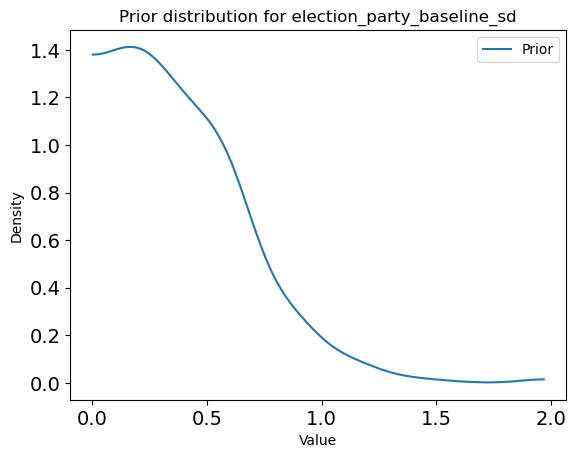

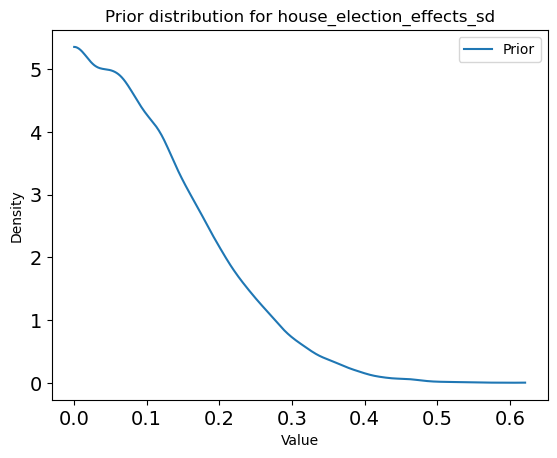

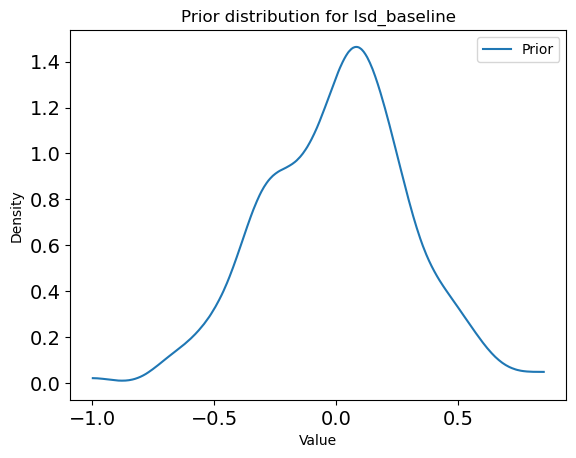

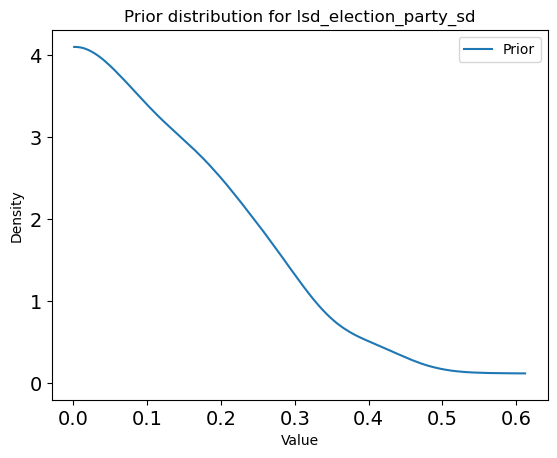

'observed_polls' not found in prior samples or observed data
'observed_results' not found in prior samples or observed data
                                                                                      mean  \
party_baseline[PS]                                                                   1.690   
party_baseline[CH]                                                                   0.074   
party_baseline[IL]                                                                  -0.742   
party_baseline[BE]                                                                   0.171   
party_baseline[CDU]                                                                  0.055   
party_baseline[PAN]                                                                 -1.550   
party_baseline[L]                                                                   -1.595   
party_baseline[AD]                                                                   1.896   
election_party_baseline[2015-1

In [ ]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np

def plot_prior(prior, var_name):
    if var_name in prior.prior:
        prior_samples = prior.prior[var_name].values
        
        if prior_samples.ndim > 1:
            # Flatten multi-dimensional arrays
            prior_samples = prior_samples.flatten()
        
        az.plot_kde(prior_samples, plot_kwargs={'label': 'Prior'})
        plt.title(f'Prior distribution for {var_name}')
        plt.xlabel('Value')
        plt.ylabel('Density')
        plt.legend()
        plt.show()
    else:
        print(f"Variable {var_name} not found in prior samples")

# Create the model
model = ElectionsModel('2024-03-10').build_model()

# List of parameters to check
params_to_check = [
    'party_baseline',
    'election_party_baseline',
    'house_election_effects',
    'poll_bias',
    'concentration_polls',
    'concentration_results',
    'party_baseline_sd',
    'election_party_baseline_sd',
    'house_election_effects_sd',
    'lsd_baseline',
    'lsd_election_party_sd'
]

# Plot prior distributions for each parameter
for param in params_to_check:
    plot_prior(prior, param)

# Generate prior predictive checks
# Plot prior predictive distributions for observed data
if 'observed_polls' in prior.observed_data and 'observed_polls' in prior.prior_predictive:
    az.plot_ppc(prior, kind='cumulative', data_pairs={"observed_polls": "observed_polls"})
    plt.title('Prior Predictive Check for Observed Polls')
    plt.show()
else:
    print("'observed_polls' not found in prior samples or observed data")

if 'observed_results' in prior.observed_data and 'observed_results' in prior.prior_predictive:
    az.plot_ppc(prior, kind='cumulative', data_pairs={"observed_results": "observed_results"})
    plt.title('Prior Predictive Check for Observed Results')
    plt.show()
else:
    print("'observed_results' not found in prior samples or observed data")

# Now proceed with the posterior analysis
import pandas as pd

# Set pandas display options to show all rows
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

summary = az.summary(trace, var_names=params_to_check)
print(summary)

# Reset pandas display options (optional)
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')
pd.reset_option('display.width')
pd.reset_option('display.max_colwidth')